In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import japanize_matplotlib

from scipy import signal
from scipy.signal import find_peaks
from scipy.integrate import cumtrapz

from datetime import datetime

import numpy as np

from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

In [2]:
# サンプリングレート(0.015秒に1回)
sampling_rate = 66

filter_num = sampling_rate * 1

In [3]:
class Data:
    def __init__(self, folder_name):
        self.folder_name = 'data/' + folder_name
        self.path = folder_name
        self.file_names = os.listdir(self.folder_name)

        self.start_time = None
        self.end_time = None

        # acceleration.csvがない場合は作成する
        if 'acceleration.csv' not in self.file_names:
            self.make_acceleration()
            self.file_names = os.listdir(self.folder_name)
        
        # 'all.csv'がある場合は削除する
        if 'all.csv' in self.file_names:
            self.file_names.remove('all.csv')
        
        self.df = pd.DataFrame()
        for file_name in self.file_names:
            df_tmp = pd.read_csv(os.path.join(self.folder_name, file_name))
            file_type = file_name.replace('.csv', '')

            # 列名を変更してファイル名を追加
            df_tmp = df_tmp.rename(columns={'x': file_type + '_x', 'y': file_type + '_y', 'z': file_type + '_z'})
            
            # 'rotate.csv' に 'w' 列がある場合は削除
            if 'w' in df_tmp.columns and file_name == 'rotate.csv':
                df_tmp = df_tmp.drop(['w'], axis=1)

            if type(df_tmp['time'][0]) == int:
                # 'time'列の変換を実行
                df_tmp['time'] = df_tmp['time'] / 1000
                df_tmp['time'] = pd.to_datetime(df_tmp['time'], unit='s')

            # df_tmpをdfに追記する,既にある列名は追記しない
            self.df = pd.concat([self.df, df_tmp], axis=1, sort=False)

            # 呼び出したファイルに上書き保存する
            df_tmp.to_csv(os.path.join(self.folder_name, file_name), index=False)

        # 1行目のtime列以外のtime列を削除する
        self.df = self.df.iloc[:, [0] + [i for i in range(1, len(self.df.columns)) if not self.df.columns[i].startswith('time')]]
        self.df['time'] =pd.to_datetime(self.df['time']/1000,unit='s')

        # csvファイルを出力する
        self.df.to_csv(os.path.join(self.folder_name, 'all.csv'), index=False)

    def make_acceleration(self):
        df_tmp = pd.read_csv(os.path.join(self.folder_name, 'velocity.csv'))
        df_acc = df_tmp
        # df_tmpからx,y,z列を削除する
        df_acc = df_acc.drop(['x', 'y', 'z'], axis=1)
        df_acc['x'] = df_tmp['x'].cumsum()
        df_acc['y'] = df_tmp['y'].cumsum()
        df_acc['z'] = df_tmp['z'].cumsum()
        df_acc.to_csv(os.path.join(self.folder_name, 'acceleration.csv'), index=False)
        df_acc = df_acc.drop(['time'],axis =1 )
        df_acc['acceleration_x'] = df_acc['x']
        df_acc['acceleration_y'] = df_acc['y']
        df_acc['acceleration_z'] = df_acc['z']
        df_acc = df_acc.drop(['x', 'y', 'z'], axis=1)
        self.df = pd.concat([self.df, df_acc], axis=1, sort=False)
        return self

    def low_filter(self, column_type, n):
        if column_type == 'all':
            for column in self.file_names:
                column = column.replace('.csv', '')
                if column == 'all':
                    pass
                self.low_filter(column, n)
        else:
            column = column_type + '_x'
            out_column = column_type + '_low_x'
            self.df[out_column] = self.df[column].rolling(n,center = True).mean()
            column = column_type + '_y'
            out_column = column_type + '_low_y'
            self.df[out_column] = self.df[column].rolling(n,center = True).mean()
            column = column_type + '_z'
            out_column = column_type + '_low_z'
            self.df[out_column] = self.df[column].rolling(n,center = True).mean()
        return self

    def high_filter(self, column_type, n):
        if column_type == 'all':
            for column in self.file_names:
                column = column.replace('.csv', '')
                if column == 'all':
                    pass
                self.high_filter(column, n)
        else:
            column = column_type + '_x'
            out_column = column_type + '_high_x'
            self.df[out_column] = self.df[column] -  self.df[column].rolling(n,center = False).mean()
            column = column_type + '_y'
            out_column = column_type + '_high_y'
            self.df[out_column] = self.df[column] -  self.df[column].rolling(n,center = False).mean()
            column = column_type + '_z'
            out_column = column_type + '_high_z'
            self.df[out_column] = self.df[column] -  self.df[column].rolling(n,center = False).mean()
        return self
    
    def diff(self, column_type):
        if column_type == 'all':
            for column in self.file_names:
                column = column.replace('.csv', '')
                if column == 'all':
                    pass
                self.diff(column)
        else:
            column = column_type + '_x'
            out_column = column_type + '_diff_x'
            self.df[out_column] = self.df[column].diff()
            column = column_type + '_y'
            out_column = column_type + '_diff_y'
            self.df[out_column] = self.df[column].diff()
            column = column_type + '_z'
            out_column = column_type + '_diff_z'
            self.df[out_column] = self.df[column].diff()
        return self

    def plot(self, column_type ,option, axis):
        self.i = 0
        self.fig = plt.figure(figsize=(15, 25))
        
        if column_type == 'all':
            # 'all.csv'がある場合は削除する
            for column in self.file_names:
                column = column.replace('.csv', '')
                if column == 'all':
                    continue
                self.ax(column, option,axis)
                self.i += 1
        else:
            column_type = column_type.replace('.csv', '')
            self.ax(column_type, option,axis)
        plt.show()

    def ax(self, column_type ,option,axis):
        self.low_filter(column_type, filter_num)
        ax = self.fig.add_subplot(5, 1, self.i+1)
        if option == "axvspan":
            self.axvspan(column_type)
        if option == "diff":
            column_type = column_type + '_diff'
        if option == "high":
            column_type = column_type + '_high'
        if option == "low":
            column_type = column_type + '_low'  
        match axis:
            case 'x':
                ax.plot(self.df['time'], self.df[column_type + '_x'], label = column_type + '_x')
            case 'y':
                ax.plot(self.df['time'], self.df[column_type + '_y'], label = column_type + '_y')
            case 'z':
                ax.plot(self.df['time'], self.df[column_type + '_z'], label = column_type + '_z')
            case _:
                ax.plot(self.df['time'], self.df[column_type + '_x'], label = column_type + '_x')
                ax.plot(self.df['time'], self.df[column_type + '_y'], label = column_type + '_y')
                ax.plot(self.df['time'], self.df[column_type + '_z'], label = column_type + '_z')
        ax.legend()
        # タイトル
        ax.set_title(column_type)
        ax.set_xlabel('time')
        ax.set_ylabel(column_type)
        ax.grid()

    def axvspan(self,column_type):
        ax.axvspan(self.start_time, self.end_time, color='red', alpha=0.5)

    def split_time(self, start_time, end_time):
        self.df = self.df[(self.df['time'] >= start_time) & (self.df['time'] <= end_time)]
        return self

In [4]:
# oculus_stairsのデータを読み込む
oculus_stairs = Data('oculus_stairs')
oculus_stairs.low_filter('all', filter_num)

In [5]:
# 時間を制限する
start_time = '2023-10-24 11:01:20'
end_time = '2023-10-24 11:02:15'
# end_time = '2023-10-24 11:01:38'
oculus_stairs.split_time(start_time, end_time)

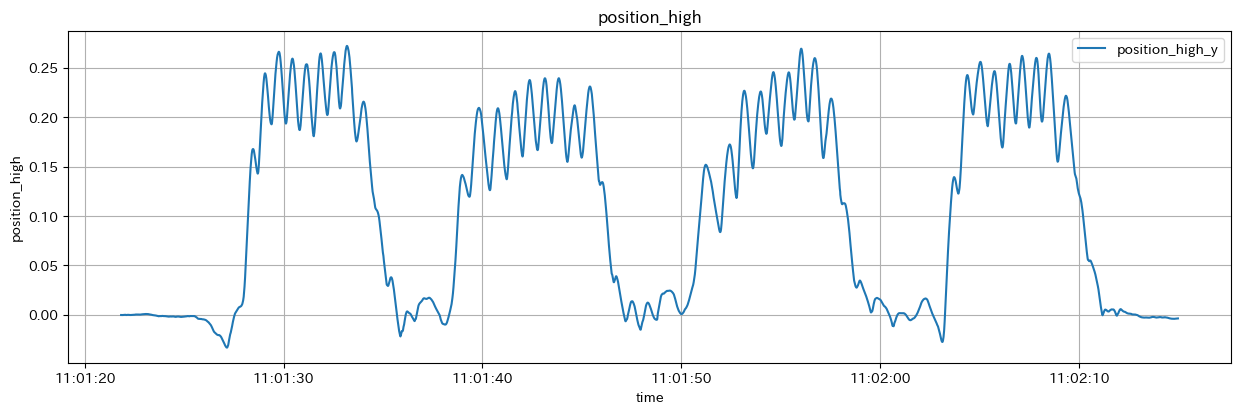

In [6]:
# dfのpositionを微分する
oculus_stairs.diff('position')
oculus_stairs.low_filter('position_diff', filter_num)
oculus_stairs.high_filter('position', filter_num*2)
oculus_stairs.plot('position', 'high','y')

In [7]:
# oculus_stairsのposition_diff_yからpeekを取得して、そのpeekの時間を取得する
peek, _ = signal.find_peaks(oculus_stairs.df['position_high_y'], distance=20, height=0.135)

peek_df = pd.DataFrame()
peek_df['time'] = oculus_stairs.df['time']

# indexの初期値を取得する
peek_first = oculus_stairs.df.index[0]

# ハイパスフィルターをかける
peek_df['position_y'] = oculus_stairs.df['position_y'] - oculus_stairs.df['position_y'].rolling(filter_num*2,center = False).mean()

# 0.5以上の時は1、0.5以下の時は0にする
peek_df['position_pro_y'] = peek_df['position_y'].apply(lambda x: 1 if x > 0.08 else 0)

# timeをずらす
peek_df['shift_time'] = peek_df['time'] - pd.Timedelta(seconds=0.5)

# 1の時のみのdfを作成する
stair_up_df = pd.DataFrame()
stair_up_df = peek_df[peek_df['position_pro_y'] == 1]

# print(peek)
# indexの初期値を取得する
peek_first = oculus_stairs.df.index[0]
# peekに初期値を足す
peek = peek + peek_first
# peekの時間を取得する
peek_time = oculus_stairs.df['time'][peek]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


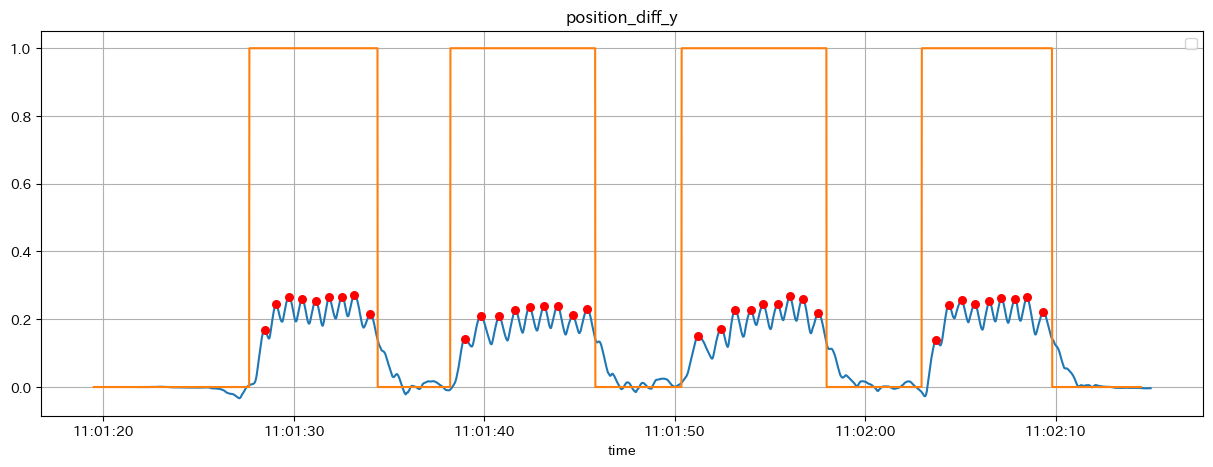

In [8]:
# plotする
fig = plt.figure(figsize=(15, 5))
plt.plot(peek_df['time'], peek_df['position_y'])
plt.plot(peek_df['shift_time'], peek_df['position_pro_y'])
# plt.plot(peek_df['time'], peek_df['position_pro_y'])
plt.scatter(peek_time, peek_df['position_y'][peek], s=30, color='red', zorder=2)
plt.title('position_diff_y')
plt.xlabel('time')
plt.legend()
plt.grid()
plt.show()

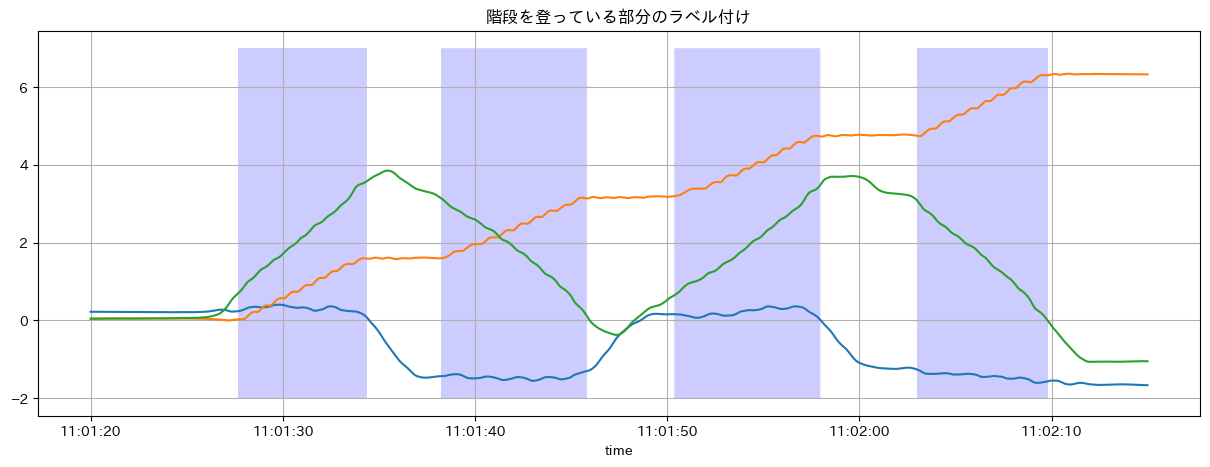

In [9]:
# position_pro_yとpositionのplot
fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(1, 1, 1)
ax.plot(oculus_stairs.df['time'], oculus_stairs.df['position_x'])
ax.plot(oculus_stairs.df['time'], oculus_stairs.df['position_y'])
ax.plot(oculus_stairs.df['time'], oculus_stairs.df['position_z'])
# 後ろを全体で塗る
ax.fill_between(peek_df['shift_time'], -2, 7, where=(peek_df['position_pro_y'] == 1), facecolor='blue', alpha=0.2)
# ax.fill_between(peek_df['time'], -2, 7, where=(peek_df['position_pro_y'] == 1), facecolor='blue', alpha=0.2)
ax.set_title('階段を登っている部分のラベル付け')
ax.set_xlabel('time')
ax.grid()
plt.show()

In [10]:
# インスタンスを使って塗りつぶしたい
#indexの初期値を取得する
peek_first = oculus_stairs.df.index[0]
peek_first_time = oculus_stairs.df['time'][peek_first]

# dfの中で初めて1になったところを取得する
start_times = []
# 最初にこのグラフの最初の時間を入れる
start_times.append(peek_first_time)
end_times = []
tmp = None  # 初めは切り替え前の値が不明です

# 'df' という名前の pandas DataFrame が 'position_pro_y' と 'time' という列を持っていることを前提とします
for i in range(peek_df.index[0], peek_df.index[-1]):
    if tmp is None:  # 初めてのイテレーションでは現在の値を設定
        tmp = peek_df['position_pro_y'][i]
        continue

    if peek_df['position_pro_y'][i] != tmp:
        # 値が切り替わったら開始時刻を保存
        start_times.append(peek_df['time'][i])
        tmp = peek_df['position_pro_y'][i]

print(start_times)


end_times = start_times[1:]
end_times.append(oculus_stairs.df['time'][peek[-1]])
print(end_times)

# インスタンスに代入
oculus_stairs.start_time = start_times[0]
oculus_stairs.end_time = end_times[0]

[Timestamp('2023-10-24 11:01:20.000999936'), Timestamp('2023-10-24 11:01:28.168999936'), Timestamp('2023-10-24 11:01:34.907000064'), Timestamp('2023-10-24 11:01:38.726000128'), Timestamp('2023-10-24 11:01:46.335000064'), Timestamp('2023-10-24 11:01:50.865999872'), Timestamp('2023-10-24 11:01:58.476000'), Timestamp('2023-10-24 11:02:03.476000'), Timestamp('2023-10-24 11:02:10.323000064')]
[Timestamp('2023-10-24 11:01:28.168999936'), Timestamp('2023-10-24 11:01:34.907000064'), Timestamp('2023-10-24 11:01:38.726000128'), Timestamp('2023-10-24 11:01:46.335000064'), Timestamp('2023-10-24 11:01:50.865999872'), Timestamp('2023-10-24 11:01:58.476000'), Timestamp('2023-10-24 11:02:03.476000'), Timestamp('2023-10-24 11:02:10.323000064'), Timestamp('2023-10-24 11:02:09.351000064')]


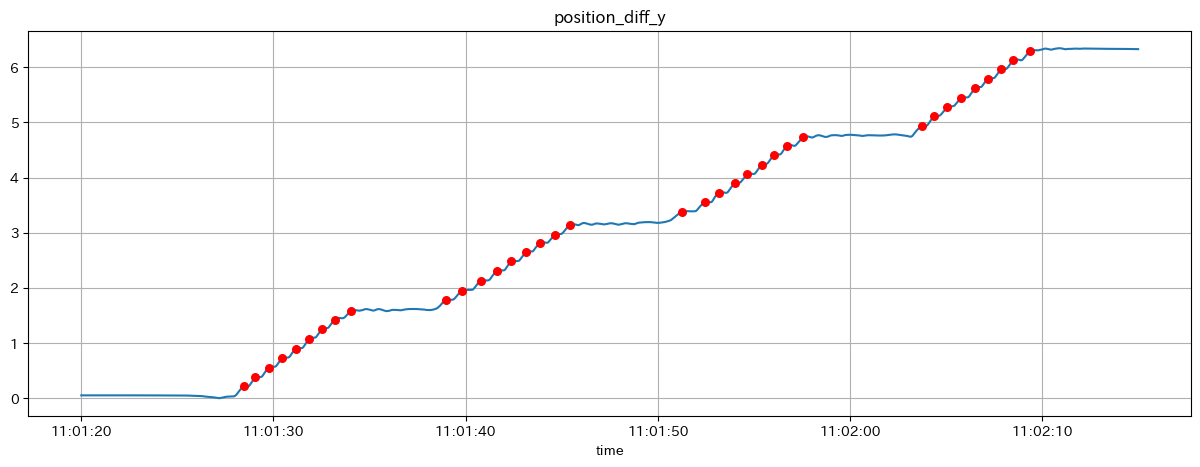

In [11]:
# peekをプロットする
fig = plt.figure(figsize=(15, 5))
plt.plot(oculus_stairs.df['time'], oculus_stairs.df['position_y'])
plt.scatter(peek_time, oculus_stairs.df['position_y'][peek], s=30, color='red', zorder=2)
plt.title('position_diff_y')
plt.xlabel('time')
plt.grid()
plt.show()

In [12]:
# stair_up_dfでindexが連続していない値を取得する
peek_observe = []
peek_observe_time = []

peek_observe.append(stair_up_df.index[0])
out = ''
tmp = 0
for i in range(len(stair_up_df.index)-1):
    if out == 'a':
        peek_observe.append(tmp)
        peek_observe.append(stair_up_df.index[i])
        out =''
        tmp = 0
        continue
    if stair_up_df.index[i] + 1 != stair_up_df.index[i+1]:
        if tmp == 0:
            tmp = stair_up_df.index[i]
        out = 'a'
peek_observe.append(stair_up_df.index[-1])

# peek_observeに対応する時間を取得する
for i in peek_observe:
    if i in oculus_stairs.df.index:
        peek_observe_time.append(oculus_stairs.df['time'][i])

print(peek_observe)
print(peek_observe_time)

[849, 1333, 1608, 2155, 2482, 3029, 3390, 3882]
[Timestamp('2023-10-24 11:01:28.168999936'), Timestamp('2023-10-24 11:01:34.895000064'), Timestamp('2023-10-24 11:01:38.726000128'), Timestamp('2023-10-24 11:01:46.323000064'), Timestamp('2023-10-24 11:01:50.865999872'), Timestamp('2023-10-24 11:01:58.464000'), Timestamp('2023-10-24 11:02:03.476000'), Timestamp('2023-10-24 11:02:10.308999936')]


In [13]:
# 登った階段の数
floor = int(len(peek_observe) / 2)
print(floor)
print(peek)
print(peek_observe)

floor_peek = []

n = 0
for i in range(floor):
    n = n + 1
    i = n+i
    tmp = []
    tmp.append(peek_observe[i-1])
    for peek_point in peek:
        if peek_observe[i-1] < peek_point and peek_point < peek_observe[i]:
            # print(peek_point)
            tmp.append(peek_point)
    # tmp.append(peek_observe[i])
    floor_peek.append(tmp)

print(floor_peek)

4
[ 870  913  963 1013 1064 1115 1164 1210 1270 1627 1687 1756 1818 1871
 1926 1977 2034 2089 2509 2595 2648 2708 2754 2809 2854 2903 2963 3408
 3456 3504 3554 3609 3655 3706 3752 3813]
[849, 1333, 1608, 2155, 2482, 3029, 3390, 3882]
[[849, 870, 913, 963, 1013, 1064, 1115, 1164, 1210, 1270], [1608, 1627, 1687, 1756, 1818, 1871, 1926, 1977, 2034, 2089], [2482, 2509, 2595, 2648, 2708, 2754, 2809, 2854, 2903, 2963], [3390, 3408, 3456, 3504, 3554, 3609, 3655, 3706, 3752, 3813]]


In [14]:
# 1段の高さ
floor_step_high = 0
floor_step_high_tmp = 0
floor_step_highs = []
for n in floor_peek:
    num = 0
    for i in range(len(n)):
        if i == len(n)-1:
            break
        before_peek_point = n[i]
        after_peek_point = n[i+1]
        stair_step = oculus_stairs.df['position_y'][after_peek_point] - oculus_stairs.df['position_y'][before_peek_point]
        # print(f"{i} after  : {oculus_stairs.df['position_y'][after_peek_point]} , before : {oculus_stairs.df['position_y'][before_peek_point]} , diff   : {stair_step}")
        floor_step_high_tmp += stair_step

    floor_step_high_tmp = floor_step_high_tmp / len(n)
    floor_step_highs.append(floor_step_high_tmp)
    print(f"1段の高さ : {floor_step_high_tmp}")

print(floor_step_highs)
average_floor_step_high = sum(floor_step_highs) / len(floor_step_highs)
print(f"平均の1段の高さ : {average_floor_step_high}")

1段の高さ : 0.14698138
1段の高さ : 0.15875563799999998
1段の高さ : 0.16075316379999996
1段の高さ : 0.15915991638000007
[0.14698138, 0.15875563799999998, 0.16075316379999996, 0.15915991638000007]
平均の1段の高さ : 0.156412524545


/var/folders/qx/g75h6sns4slc8l4sb8lsy3l00000gn/T/ipykernel_98738/154816400.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  floor_step_df['floor_step_high'][peek_point] = tmp + floor_step_highs[i]


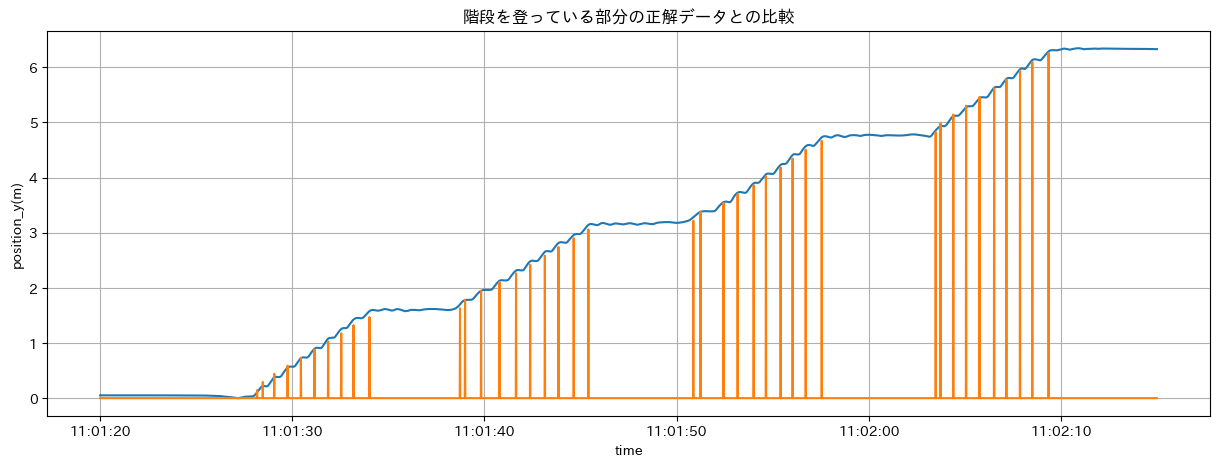

In [15]:
# peekの時間に合わせて、floor_step_highsを加算したリストを作成する
floor_step_df = pd.DataFrame()
floor_step_df['time'] = oculus_stairs.df['time']
floor_step_df['position_y'] = oculus_stairs.df['position_y']
floor_step_df['position_pro_y'] = peek_df['position_pro_y']
floor_step_df['floor_step_high'] = 0

# floor_step_dfにfloor_step_highsを加算する
n = 0
tmp = 0
for i in range(floor):
    # floor_peekに入っているpeekの数だけ繰り返す
    for peek_point in floor_peek[i]:
        floor_step_df['floor_step_high'][peek_point] = tmp + floor_step_highs[i]
        tmp = tmp + floor_step_highs[i]

# plotする
fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(1, 1, 1)
ax.plot(floor_step_df['time'], floor_step_df['position_y'])
ax.plot(floor_step_df['time'], floor_step_df['floor_step_high'])
ax.set_title('階段を登っている部分の正解データとの比較')
ax.set_xlabel('time')
ax.set_ylabel('position_y(m)')
ax.grid()
plt.show()

/var/folders/qx/g75h6sns4slc8l4sb8lsy3l00000gn/T/ipykernel_98738/464037005.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  floor_step_df['floor_step_high'][peek_point] = tmp + average_floor_step_high


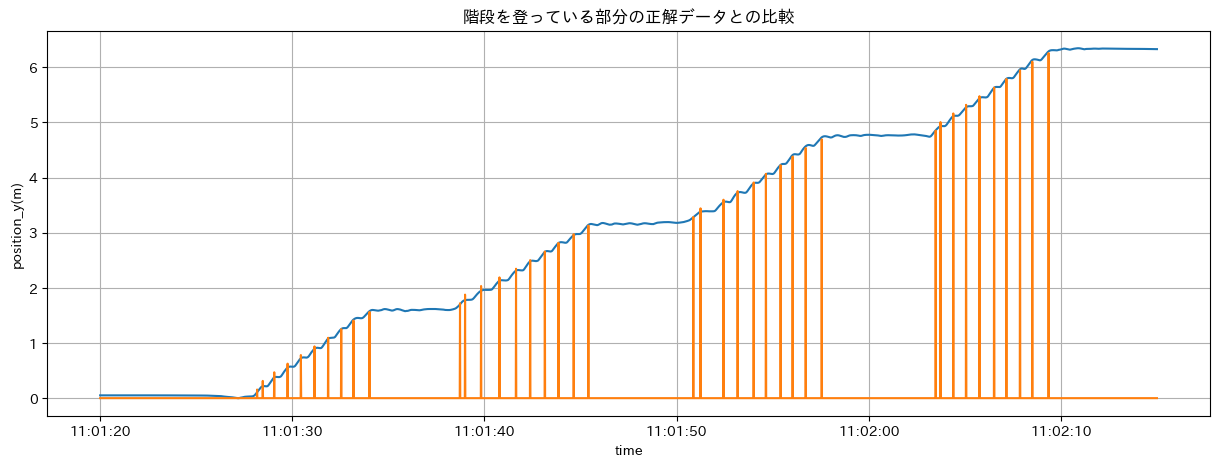

In [16]:
# peekの時間に合わせて、floor_step_highsを加算したリストを作成する
floor_step_df = pd.DataFrame()
floor_step_df['time'] = oculus_stairs.df['time']
floor_step_df['position_y'] = oculus_stairs.df['position_y']
floor_step_df['position_pro_y'] = peek_df['position_pro_y']
floor_step_df['floor_step_high'] = 0

# floor_step_dfにfloor_step_highsを加算する
n = 0
tmp = 0
for i in range(floor):
    # floor_peekに入っているpeekの数だけ繰り返す
    for peek_point in floor_peek[i]:
        floor_step_df['floor_step_high'][peek_point] = tmp + average_floor_step_high
        tmp = tmp + average_floor_step_high

# plotする
fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(1, 1, 1)
ax.plot(floor_step_df['time'], floor_step_df['position_y'])
ax.plot(floor_step_df['time'], floor_step_df['floor_step_high'])
ax.set_title('階段を登っている部分の正解データとの比較')
ax.set_xlabel('time')
ax.set_ylabel('position_y(m)')
ax.grid()
plt.show()

In [17]:
# floor_step_df['floor_step_high']の値が0のとき、floor_step_df['floor_step_high']の値をそれまでの最大値にする
floor_step_df['floor_step_high_pro'] = floor_step_df['floor_step_high']
for i in range(len(floor_step_df['floor_step_high_pro'])):
    floor_step_df['floor_step_high_pro'][i] = floor_step_df['floor_step_high_pro'][:i].max()

floor_step_df['shift_time'] = floor_step_df['time'] + pd.Timedelta(seconds=3.7)

/var/folders/qx/g75h6sns4slc8l4sb8lsy3l00000gn/T/ipykernel_98738/2661272064.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  floor_step_df['floor_step_high_pro'][i] = floor_step_df['floor_step_high_pro'][:i].max()
/var/folders/qx/g75h6sns4slc8l4sb8lsy3l00000gn/T/ipykernel_98738/2661272064.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  floor_step_df['floor_step_high_pro'][i] = floor_step_df['floor_step_high_pro'][:i].max()
/var/folders/qx/g75h6sns4slc8l4sb8lsy3l00000gn/T/ipykernel_98738/2661272064.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in

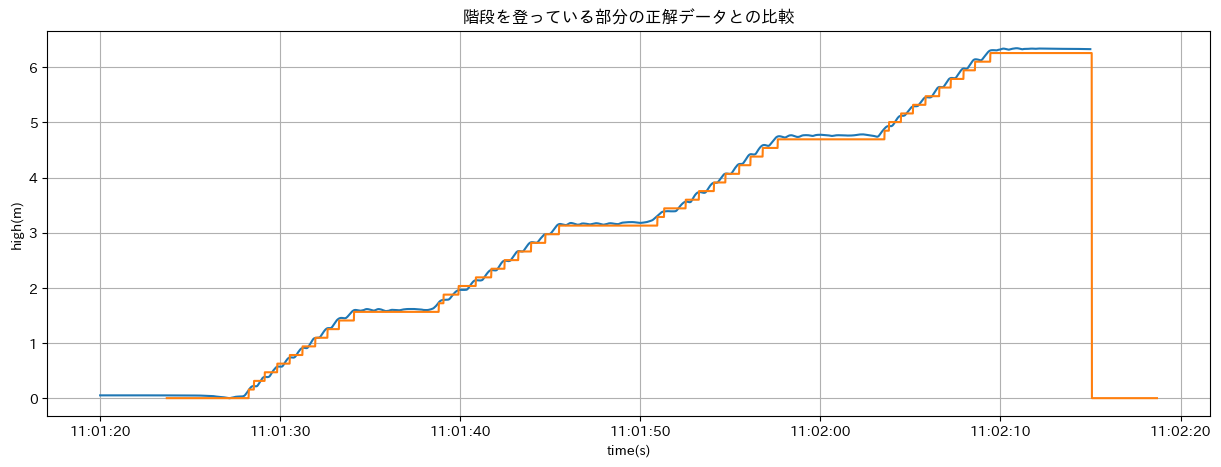

In [18]:
# floor_step_dfの['floor_step_high']を表示する
fig = plt.figure(figsize=(15, 5))
plt.plot(floor_step_df['time'], floor_step_df['position_y'])
# plt.plot(floor_step_df['time'], floor_step_df['floor_step_high'])
plt.plot(floor_step_df['shift_time'], floor_step_df['floor_step_high_pro'])
plt.title('階段を登っている部分の正解データとの比較')
plt.xlabel('time(s)')
plt.ylabel('high(m)')
plt.grid()
plt.show()

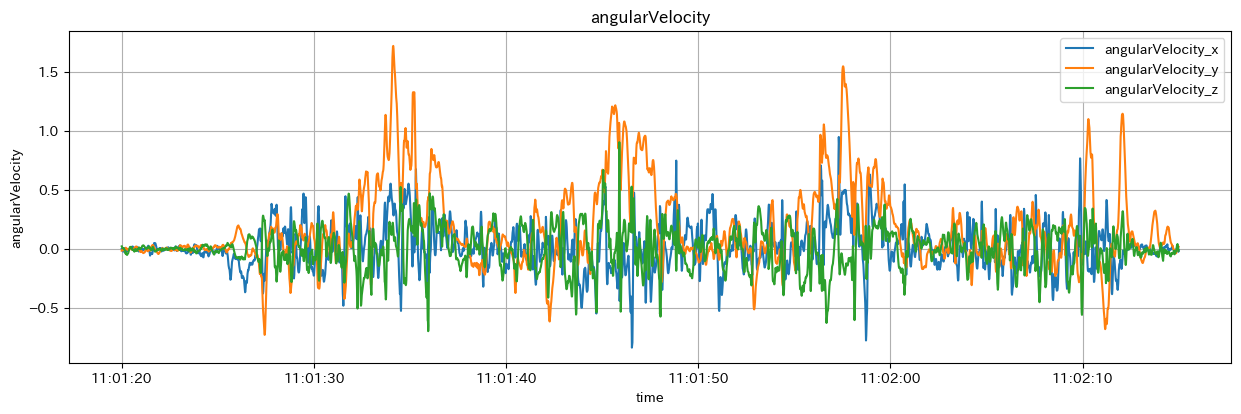

In [19]:
oculus_stairs.plot('angularVelocity', 'all','')

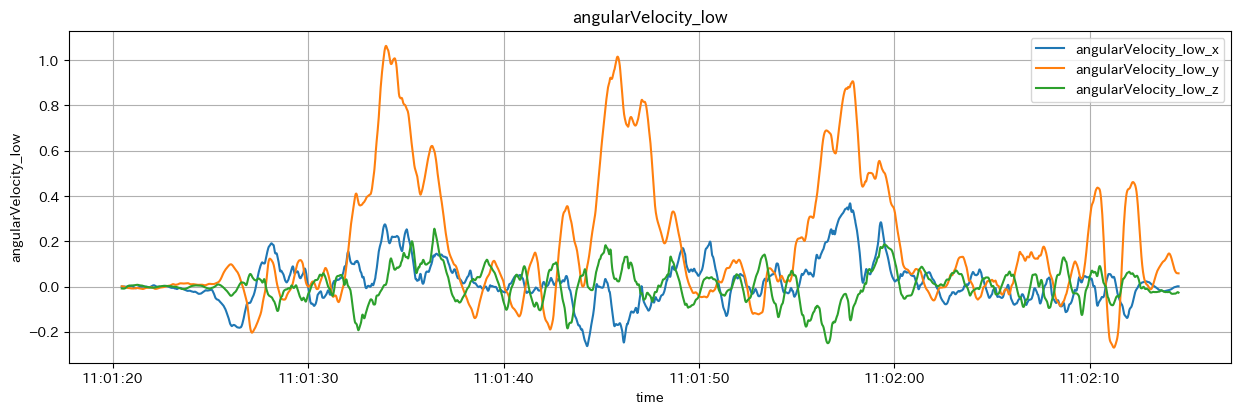

In [20]:
oculus_stairs.low_filter('angularVelocity', filter_num)
oculus_stairs.plot('angularVelocity_low', '','')

[1007 1175 1859 1949 2628 2725]
261
[1268 1436 2120 2210 2889 2986]
1268   2023-10-24 11:01:33.989000192
1436   2023-10-24 11:01:36.336999936
2120   2023-10-24 11:01:45.835000064
2210   2023-10-24 11:01:47.085999872
2889   2023-10-24 11:01:56.517999872
2986   2023-10-24 11:01:57.864999936
Name: time, dtype: datetime64[ns]


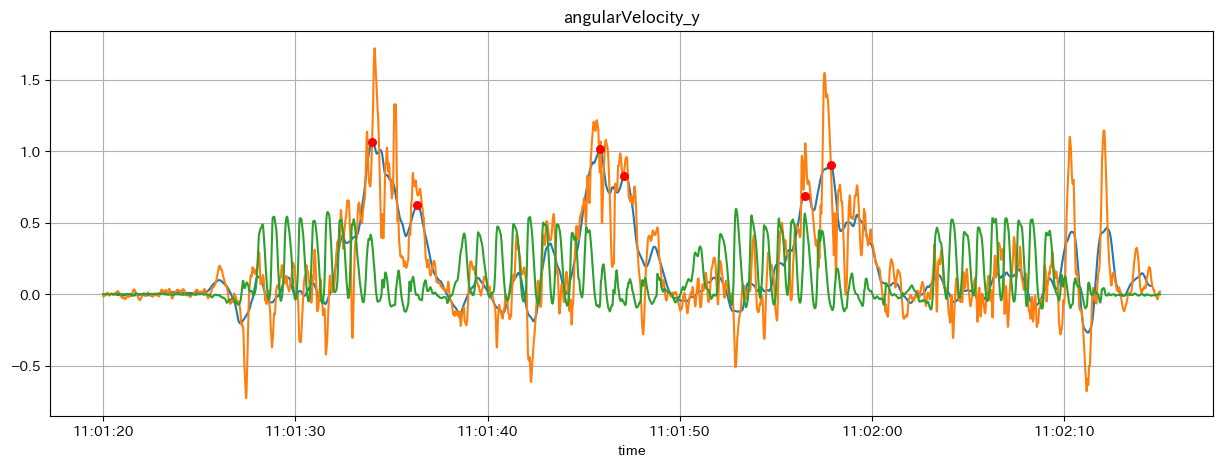

In [28]:
# peek
peek, _ = signal.find_peaks(oculus_stairs.df['angularVelocity_low_y'], distance=66, height=0.6)
print(peek)

print(oculus_stairs.df.index[0])

peek = peek + oculus_stairs.df.index[0]

print(peek)

# peekの時間を取得する
peek_time = oculus_stairs.df['time'][peek]
print(peek_time)

# plotする
fig = plt.figure(figsize=(15, 5))
plt.plot(oculus_stairs.df['time'], oculus_stairs.df['angularVelocity_low_y'])
plt.plot(oculus_stairs.df['time'], oculus_stairs.df['angularVelocity_y'])
plt.plot(oculus_stairs.df['time'], oculus_stairs.df['velocity_y'])
plt.scatter(peek_time, oculus_stairs.df['angularVelocity_low_y'][peek], s=30, color='red', zorder=2)
plt.title('angularVelocity_y')
plt.xlabel('time')
plt.grid()
plt.show()


[ 597  640  688  737  792  841  891  938 1002 1351 1404 1476 1537 1598
 1647 1699 1756 1809 2311 2370 2427 2475 2530 2582 2627 2681 3122 3178
 3225 3277 3331 3380 3428 3479 3545]
261
[ 858  901  949  998 1053 1102 1152 1199 1263 1612 1665 1737 1798 1859
 1908 1960 2017 2070 2572 2631 2688 2736 2791 2843 2888 2942 3383 3439
 3486 3538 3592 3641 3689 3740 3806]
858    2023-10-24 11:01:28.296000000
901    2023-10-24 11:01:28.892999936
949    2023-10-24 11:01:29.558000128
998    2023-10-24 11:01:30.239000064
1053   2023-10-24 11:01:31.003000064
1102   2023-10-24 11:01:31.683000064
1152   2023-10-24 11:01:32.379000064
1199   2023-10-24 11:01:33.030999808
1263   2023-10-24 11:01:33.917999872
1612   2023-10-24 11:01:38.780000000
1665   2023-10-24 11:01:39.516999936
1737   2023-10-24 11:01:40.515000064
1798   2023-10-24 11:01:41.362999808
1859   2023-10-24 11:01:42.211000064
1908   2023-10-24 11:01:42.890000128
1960   2023-10-24 11:01:43.611000064
2017   2023-10-24 11:01:44.404000000
2070   20

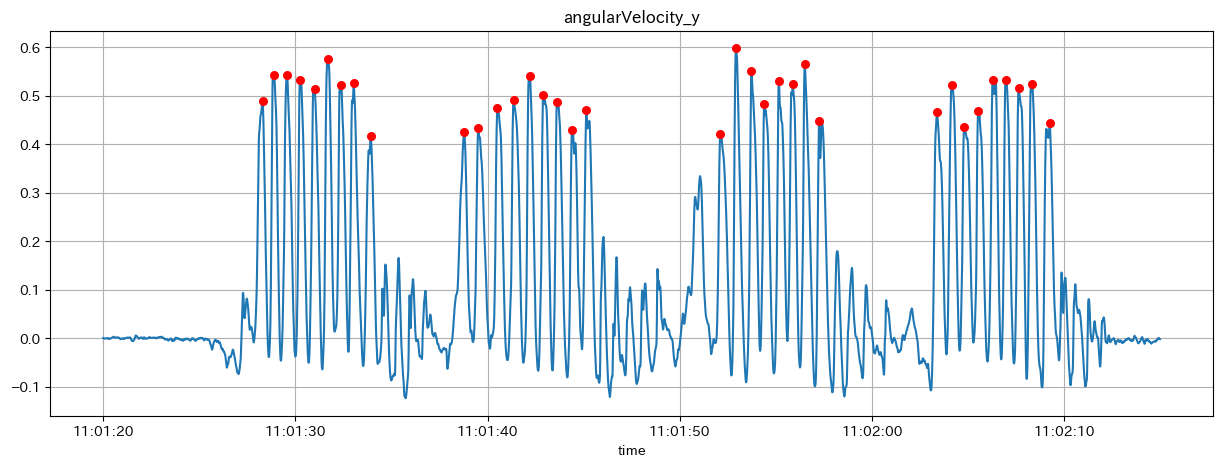

In [34]:
# peekを検出
velocity_peek, _ = signal.find_peaks(oculus_stairs.df['velocity_y'], distance=22, height=0.4)

print(velocity_peek)

print(oculus_stairs.df.index[0])

velocity_peek = velocity_peek + oculus_stairs.df.index[0]

print(velocity_peek)

# peekの時間を取得する
velocity_peek_time = oculus_stairs.df['time'][velocity_peek]
print(velocity_peek_time)

# plotする
fig = plt.figure(figsize=(15, 5))
plt.plot(oculus_stairs.df['time'], oculus_stairs.df['velocity_y'])
plt.scatter(velocity_peek_time, oculus_stairs.df['velocity_y'][velocity_peek], s=30, color='red', zorder=2)
plt.title('angularVelocity_y')
plt.xlabel('time')
plt.grid()
plt.show()

/var/folders/qx/g75h6sns4slc8l4sb8lsy3l00000gn/T/ipykernel_98738/1618082020.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  oculus_stairs.df['velocity_pro_high_y'][index] = 0
/var/folders/qx/g75h6sns4slc8l4sb8lsy3l00000gn/T/ipykernel_98738/1618082020.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  oculus_stairs.df['velocity_pro_high_y'][index] = 0
/var/folders/qx/g75h6sns4slc8l4sb8lsy3l00000gn/T/ipykernel_98738/1618082020.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gui

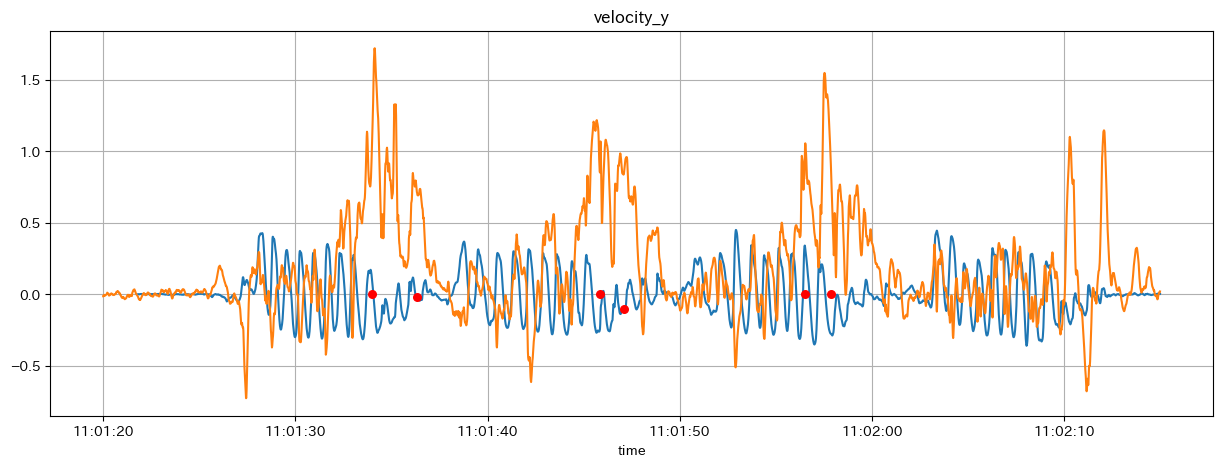

In [29]:
# velocityにハイカットフィルターをかける
# 0.25以上の時は0にする、それ以外はそのまま
oculus_stairs.high_filter('velocity', filter_num*2)
oculus_stairs.df['velocity_pro_high_y'] = oculus_stairs.df['velocity_high_y']

# oculus_stairs.df['velocity_pro_y']のtimeがpeek_df['position_pro_y'] == 1のところを0にする
for index in peek_df.index:
    if peek_df['position_pro_y'][index] == 1:
        index -= 33
        oculus_stairs.df['velocity_pro_high_y'][index] = 0

oculus_stairs.df['velocity_pro_y'] = oculus_stairs.df['velocity_high_y'].apply(lambda x: 0 if x > 0.25 else x)

# plotする
fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(1, 1, 1)

# ax.plot(oculus_stairs.df['time'], oculus_stairs.df['velocity_y'])
ax.plot(oculus_stairs.df['time'], oculus_stairs.df['velocity_high_y'])
# ax.plot(oculus_stairs.df['time'], oculus_stairs.df['velocity_pro_high_y'])
ax.plot(oculus_stairs.df['time'], oculus_stairs.df['angularVelocity_y'])
# ax.plot(oculus_stairs.df['time'], oculus_stairs.df['velocity_pro_y'])

# ax.fill_between(peek_df['shift_time'], -0.4, 0.4, where=(peek_df['position_pro_y'] == 1), facecolor='blue', alpha=0.2)
ax.scatter(peek_time, oculus_stairs.df['velocity_pro_high_y'][peek], s=30, color='red', zorder=2)
plt.title('velocity_y')
plt.xlabel('time')
plt.grid()
plt.show()

In [24]:
# angular_velocityのyの最大値を取得する
max = oculus_stairs.df['angularVelocity_y'].max()
print(max)

# indexを取得する
index = oculus_stairs.df[oculus_stairs.df['angularVelocity_y'] == max].index

# その時間を取得する
time = oculus_stairs.df[oculus_stairs.df['angularVelocity_y'] == max]['time']
print(time)

1.720787
1278   2023-10-24 11:01:34.128999936
Name: time, dtype: datetime64[ns]


In [25]:
# peekとindexで一番近い値を取得する
near = peek[np.abs(peek - index[0]).argmin()]
print(near)

1268


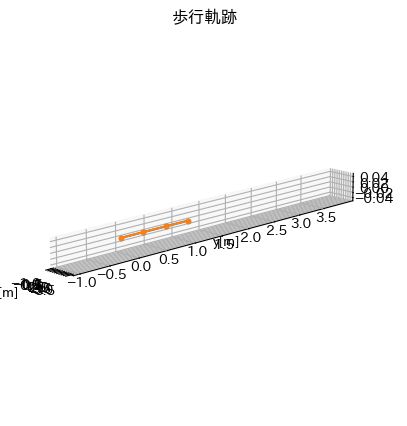

In [26]:
# 軌跡を描く
step = 0.4
x,y,z = 0,0,0
point = [[0, 0,0]]
for p in peek:
    if p < near:
        x += step
        y += 0
        z += 0
    else:
        x += 0
        y += step
        z += 0

    point.append([x, y,z])

# pointの[0,0]を削除する
point.pop(0)

point = pd.DataFrame(data=point, columns=['x', 'y','z'])

point['x'] = point['x'] - point['x'][0]
point['y'] = point['y'] - point['y'][0]
point['z'] = point['z'] - point['z'][0]

size = ((-1,4),(-1,4))

# plot
fig = plt.figure(figsize=(15, 5))

ax = fig.add_subplot(projection='3d')
ax.plot(point['x'], point['y'], point['z'], '.-', zorder=1)

plt.plot(point['x'], point['y'], '.-', label='推定', zorder=1)
plt.gca().set_aspect('equal', adjustable='box')

plt.title('歩行軌跡')
plt.xlabel('x[m]')
plt.ylabel('y[m]')

plt.xticks(np.arange(size[0][0], size[0][1], 0.5))
plt.yticks(np.arange(size[1][0], size[1][1], 0.5))
plt.xlim(size[0][0], size[0][1])
plt.ylim(size[1][0], size[1][1])

# 視野の調整
ax.view_init(azim=-45,elev=15)

plt.show()
